# Azure AutoML for Images

## AutoML for Images to train and a deploy an object detection model (Part 1)

**Important:** This feature is currently in public preview. This preview version is provided without a service-level agreement. Certain features might not be supported or might have constrained capabilities. For more information, see [Supplemental Terms of Use for Microsoft Azure Previews](https://azure.microsoft.com/en-us/support/legal/preview-supplemental-terms/).

Serge Retkowsky | serge.retkowsky@microsoft.com | V1 21-June-2022

In this notebook you will:
- Create an Azure ML experiment
- Download some images files to train an object detection model. In this example we will try to detect Covid19 masks from a picture.
- We will use some preannotated images 
- Use AutoML for Images to build and train an object detection model
- Do some advanced hyperparameter tuning using AutoML for Images advanced options
- Deploy the computer vision model into Azure Kubernetes Service
- You will test the model in a separate notebook

### AutoML for Images links:
What is AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/concept-automated-ml#computer-vision-preview

Algorithms<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

Tutorials<br>
https://docs.microsoft.com/en-us/azure/machine-learning/v1/tutorial-auto-train-image-models-v1

ONNX<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-inference-onnx-automl-image-models?tabs=multi-class

How to use AutoML for Images?<br>
https://docs.microsoft.com/en-us/azure/machine-learning/how-to-use-automl-small-object-detect<br>
https://docs.microsoft.com/en-us/azure/machine-learning/v1/how-to-auto-train-image-models-v1

In [1]:
import numpy as np
import json
import os
import urllib
import datetime
import requests
import azureml.core
import humanize
import os.path
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from zipfile import ZipFile
from PIL import Image as pil_image
from os import path

In [2]:
import sys
print("Python version =", sys.version)

Python version = 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]


In [3]:
print("Today:", datetime.datetime.now())

Today: 2022-06-21 11:52:42.594621


In [4]:
print("This notebooks was made using Azure ML version 1.41")
print("You are using Azure ML =", azureml.core.VERSION)

This notebooks was made using Azure ML version 1.41
You are using Azure ML = 1.41.0


In [5]:
# Your local environment
import platform, socket, re, uuid, json, psutil, logging


def getSystemInfo():
    try:
        info = {}
        info['Platform'] = platform.system()
        info['Platform-release'] = platform.release()
        info['Platform-version'] = platform.version()
        info['Architecture'] = platform.machine()
        info['Hostname'] = socket.gethostname()
        info['IP-address'] = socket.gethostbyname(socket.gethostname())
        info['MAC-address'] = ':'.join(
            re.findall('..', '%012x' % uuid.getnode()))
        info['Processor'] = platform.processor()
        info['RAM'] = str(round(psutil.virtual_memory().total /
                                (1024.0**3))) + " Gb"
        return json.dumps(info)

    except Exception as e:
        logging.exception(e)


print("Your local environment:")
json.loads(getSystemInfo())

Your local environment:


{'Platform': 'Linux',
 'Platform-release': '5.4.0-1077-azure',
 'Platform-version': '#80~18.04.1-Ubuntu SMP Wed Apr 13 02:07:09 UTC 2022',
 'Architecture': 'x86_64',
 'Hostname': 'standardd13',
 'IP-address': '127.0.0.1',
 'MAC-address': '60:45:bd:90:9b:99',
 'Processor': 'x86_64',
 'RAM': '55 Gb'}

In [6]:
def listfiles(MYDIR):

    print("Files in:", MYDIR, "\n")

    for file in os.scandir(MYDIR):
        print(datetime.datetime.fromtimestamp(file.stat().st_atime), file.name,
              humanize.naturalsize(file.stat().st_size))

## 2. Workspace setup
In order to train and deploy models in Azure ML, you will first need to set up a workspace.

An [Azure ML Workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#workspace) is an Azure resource that organizes and coordinates the actions of many other Azure resources to assist in executing and sharing machine learning workflows. In particular, an Azure ML Workspace coordinates storage, databases, and compute resources providing added functionality for machine learning experimentation, deployment, inference, and the monitoring of deployed models.

Create an Azure ML Workspace within your Azure subscription or load an existing workspace.

In [7]:
your_azure_id = "tobereplaced"
your_azureml_workspace_resourcegroup = "tobereplaced"
your_azurelml_workspace = "tobereplaced"

In [8]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", your_azure_id)
resource_group = os.environ.get("RESOURCE_GROUP",
                                your_azureml_workspace_resourcegroup)
workspace_name = os.environ.get("WORKSPACE_NAME", your_azurelml_workspace)

In [9]:
from azureml.core import Workspace

try:
    ws = Workspace(subscription_id=subscription_id,
                   resource_group=resource_group,
                   workspace_name=workspace_name)
    
    ws.write_config()
    print("[OK] Workspace configuration saved.")

except:
    print("[Error] Workspace not found!")

[OK] Workspace configuration saved.


In [10]:
try:
    print("Loading Azure ML workspace config...")
    ws = Workspace.from_config()
    # ws.get_details()
    print("\n[OK] Workspace is available:")
    print("Azure ML workspace:", ws.name)
    print("Azure ML resource group:", ws.resource_group)

except:
    print("[Error] Cannot load configuration")

Loading Azure ML workspace config...

[OK] Workspace is available:
Azure ML workspace: azuremlvision
Azure ML resource group: azuremlvision-rg


Now we can define a GPU compute target to train the model

## 3. Compute target setup
You will need to provide a [Compute Target](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#computes) that will be used for your AutoML model training. AutoML models for image tasks require [GPU SKUs](https://docs.microsoft.com/en-us/azure/virtual-machines/sizes-gpu) such as the ones from the NC, NCv2, NCv3, ND, NDv2 and NCasT4 series. We recommend using the NCsv3-series (with v100 GPUs) for faster training. Using a compute target with a multi-GPU VM SKU will leverage the multiple GPUs to speed up training. Additionally, setting up a compute target with multiple nodes will allow for faster model training by leveraging parallelism, when tuning hyperparameters for your model.

In [90]:
from azureml.core.compute import AmlCompute, ComputeTarget

cluster_name = "AutoML-GPU-cluster"

try:
    compute_target = ws.compute_targets[cluster_name]
    print("Found existing compute target.")

except KeyError:
    print("Creating a new compute target...")
    compute_config = AmlCompute.provisioning_configuration(
        vm_size="Standard_NC6",
        idle_seconds_before_scaledown=1800,
        min_nodes=0,
        max_nodes=4,
    )
    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output=True,
                                   min_node_count=None,
                                   timeout_in_minutes=20)

Creating a new compute target...
InProgress....
SucceededProvisioning operation finished, operation "Succeeded"
Succeeded
AmlCompute wait for completion finished

Minimum number of nodes requested have been provisioned


In [12]:
# Compute status
compute_target.provisioning_state

'Succeeded'

In [13]:
# Compute cluster information
compute_target.get_status().serialize()

{'currentNodeCount': 0,
 'targetNodeCount': 0,
 'nodeStateCounts': {'preparingNodeCount': 0,
  'runningNodeCount': 0,
  'idleNodeCount': 0,
  'unusableNodeCount': 0,
  'leavingNodeCount': 0,
  'preemptedNodeCount': 0},
 'allocationState': 'Resizing',
 'allocationStateTransitionTime': '2022-06-21T11:52:56.725000+00:00',
 'errors': None,
 'creationTime': '2022-06-21T11:52:56.212084+00:00',
 'modifiedTime': '2022-06-21T11:53:02.954361+00:00',
 'provisioningState': 'Succeeded',
 'provisioningStateTransitionTime': None,
 'scaleSettings': {'minNodeCount': 0,
  'maxNodeCount': 4,
  'nodeIdleTimeBeforeScaleDown': 'PT1800S'},
 'vmPriority': 'Dedicated',
 'vmSize': 'STANDARD_NC6'}

In [14]:
compute_targets = ws.compute_targets

print("List of all the compute instances in your Azure ML workspace:")
for name, ct in compute_targets.items():
    print("-", name, "(", ct.type, ") :", ct.provisioning_state)

List of all the compute instances in your Azure ML workspace:
- aks-cluster ( AKS ) : Succeeded
- aks-clustertest ( AKS ) : Succeeded
- DefLabelNC6 ( AmlCompute ) : Succeeded
- seretkow9 ( ComputeInstance ) : Succeeded
- seretkow5 ( ComputeInstance ) : Succeeded
- gpucomputeinstance ( ComputeInstance ) : Succeeded
- cpucomputeinstance ( ComputeInstance ) : Succeeded
- cpud13v2 ( ComputeInstance ) : Succeeded
- standardd13 ( ComputeInstance ) : Succeeded
- AutoMLGPU ( AmlCompute ) : Succeeded
- AutoML-GPU ( AmlCompute ) : Succeeded


Now can create or access to an Azure ML experiment

## 4. Experiment Setup
Create an [Experiment](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#experiments) in your workspace to track your model training runs

In [15]:
from azureml.core import Experiment

experiment_name = "AutomlforImages-MaskDetection"
experiment = Experiment(ws, name=experiment_name)
experiment

Name,Workspace,Report Page,Docs Page
AutomlforImages-MaskDetection,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


Now we can download the images

## 5. Dataset with input Training Data

In order to generate models for computer vision, you will need to bring in labeled image data as input for model training in the form of an [AzureML Tabular Dataset](https://docs.microsoft.com/en-us/python/api/azureml-core/azureml.data.tabulardataset). You can either use a dataset that you have exported from a [Data Labeling](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-label-data) project, or create a new Tabular Dataset with your labeled training data.

In [17]:
print("1. Downloading zip file...")
download_url = "https://github.com/retkowsky/CustomVision_Datasets/raw/master/covid19images.zip"
zip_file = "covid19images.zip"
urllib.request.urlretrieve(download_url, filename=zip_file)
print("Done.")

print("\n2. Unzipping file...")
with ZipFile(zip_file, "r") as zip:
    print("extracting files...")
    zip.extractall()
print("Done.")

print("\n3. Removing zip file...")
os.remove(zip_file)
print("Done.")

1. Downloading zip file...
Done.

2. Unzipping file...
extracting files...
Done.

3. Removing zip file...
Done.


In [18]:
train_dir = "train"
valid_dir = "valid"

nbfiles_train = sum(len(files) for _, _, files in os.walk(train_dir))
print("Number of files in directory", train_dir, "=", nbfiles_train)

nbfiles_val = sum(len(files) for _, _, files in os.walk(valid_dir))
print("Number of files in directory", valid_dir, "=", nbfiles_val)

Number of files in directory train = 106
Number of files in directory valid = 30


This is a sample image from this dataset:

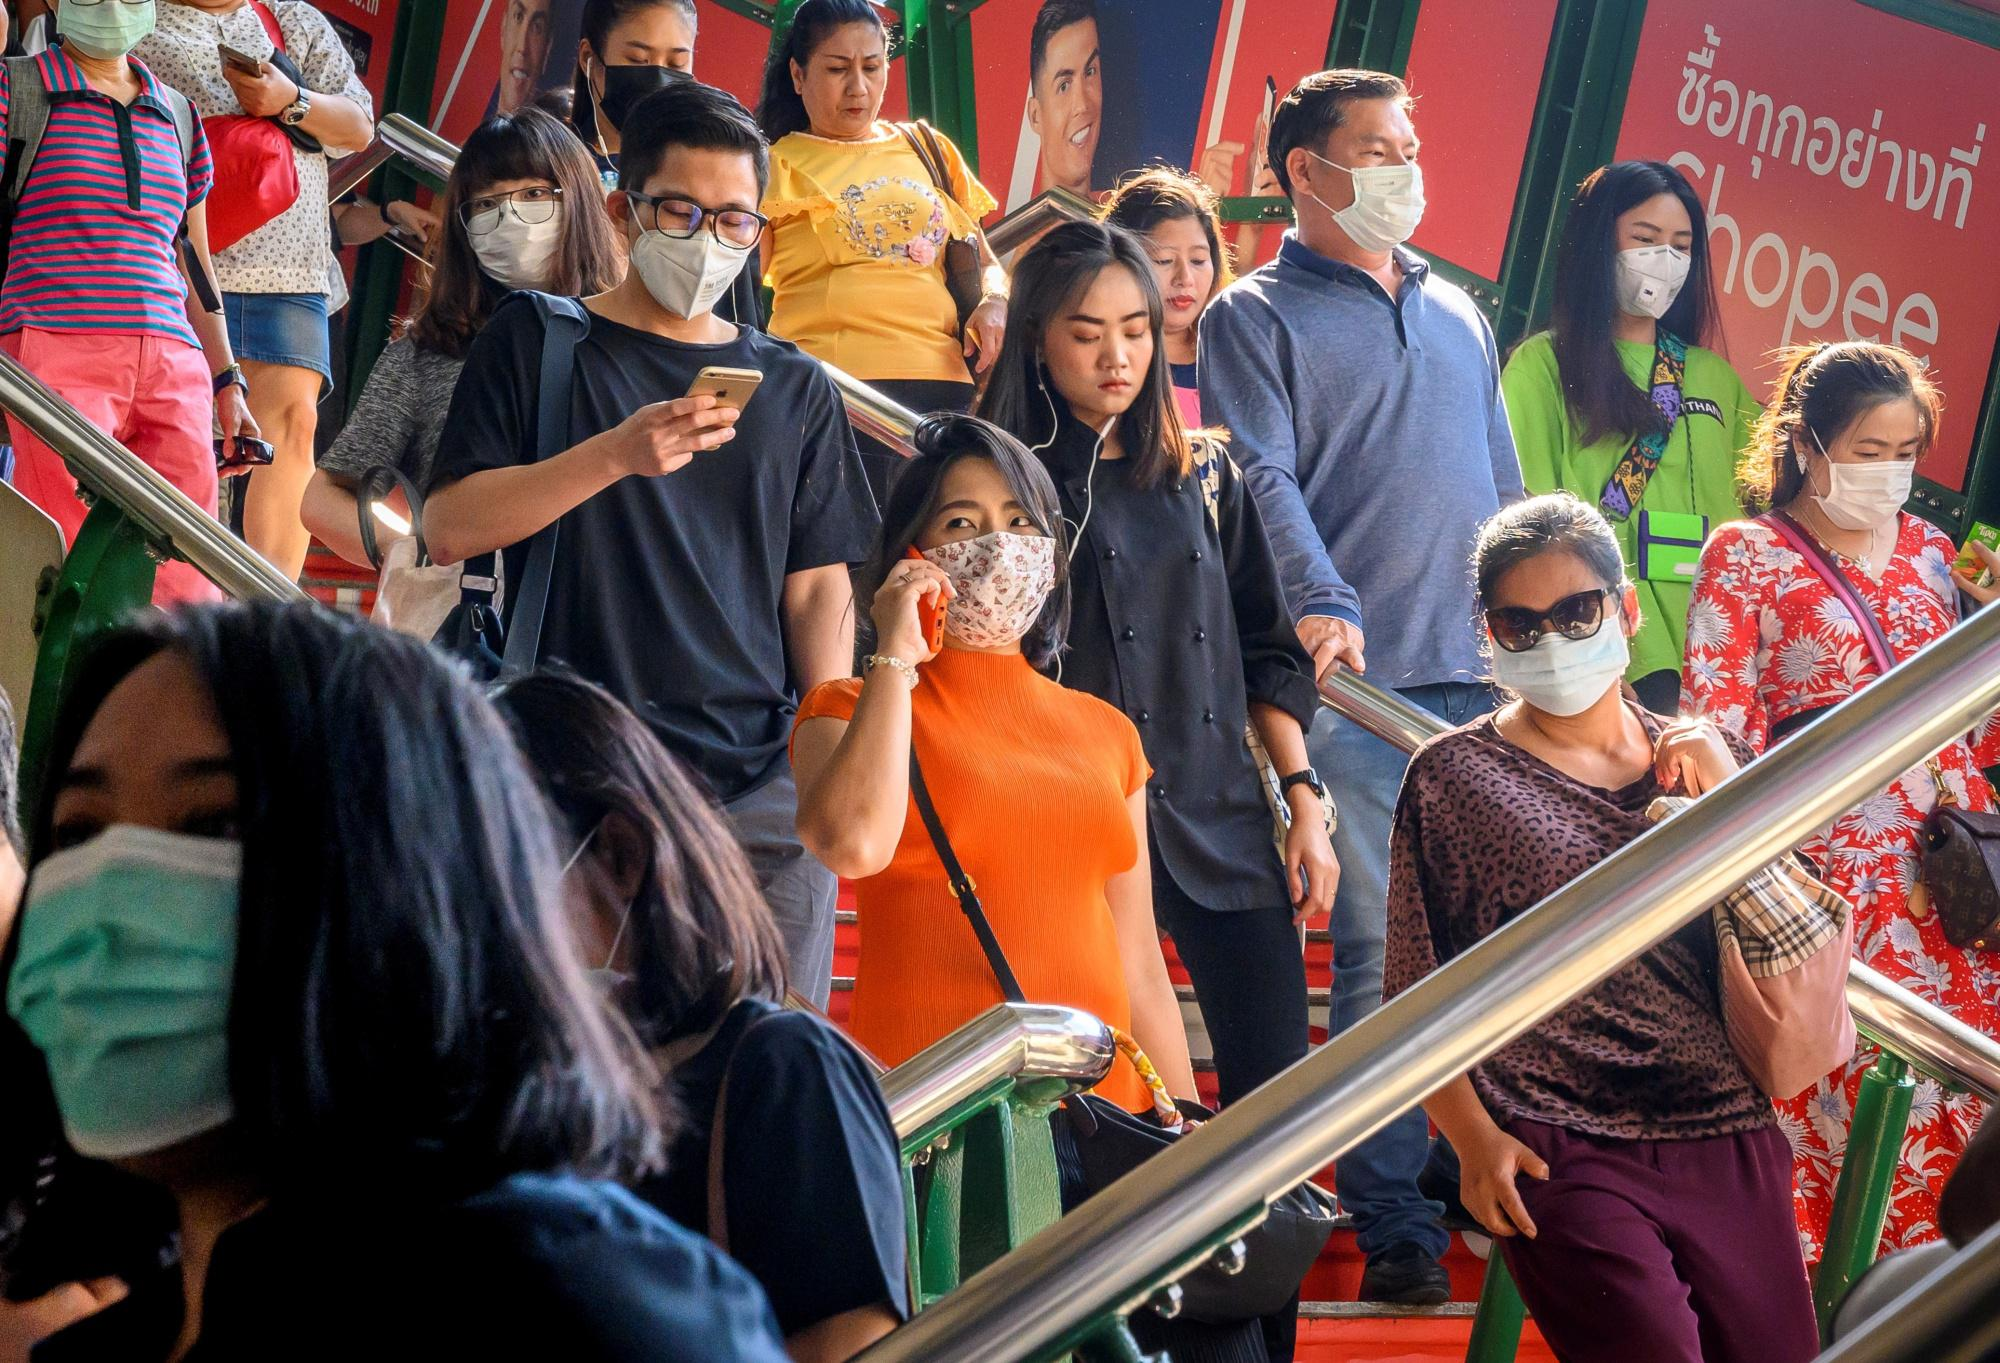

In [19]:
from IPython.display import Image

sample_image = train_dir + '/-1x-1_jpg.rf.69d9b61e3cdb8a9047dad25099fcc8ef.jpg'
Image(filename=sample_image, width=640, height=480)

### Convert annotation file from COCO to JSONL


These images are already labelled so there is no need to use Azure ML Data Labelling. But we need to transform the initial COCO file format (labels) to the Azure ML required JSONL file for the labels. Next we will run a python script that will do the job.

### For the training images

In [21]:
# Generate annotation jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./train/annotationscoco.json" \
--output_dir "./train" --output_file_name "covidmask_train.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://workspaceblobstore/train/"

Converting for ObjectDetection


In [22]:
!ls train/covidmask_train.jsonl -lh

-rwxrwxrwx 1 root root 107K Jun 21 11:56 train/covidmask_train.jsonl


### For the validation images

In [23]:
# Generate annotation jsonl file from coco file
!python coco2jsonl.py \
--input_coco_file_path "./valid/annotationscoco.json" \
--output_dir "./valid" --output_file_name "covidmask_valid.jsonl" \
--task_type "ObjectDetection" \
--base_url "AmlDatastore://workspaceblobstore/valid/"

Converting for ObjectDetection


In [24]:
!ls valid/covidmask_valid.jsonl -lh

-rwxrwxrwx 1 root root 26K Jun 21 11:56 valid/covidmask_valid.jsonl


So we have our images and labels. We can display some training images with the labels

### Visualize bounding boxes

In [33]:
def plot_ground_truth_boxes(image_file, ground_truth_boxes):
    
    nb_masks = nb_nomasks = 0
    plt.figure()
    img_np = mpimg.imread(image_file)
    img = pil_image.fromarray(img_np.astype("uint8"), "RGB")
    img_w, img_h = img.size

    fig,ax = plt.subplots(figsize=(12, 16))
    ax.imshow(img_np)
    ax.axis("off")

    for gt in ground_truth_boxes:
        label = gt["label"]

        xmin, ymin, xmax, ymax =  gt["topX"], gt["topY"], gt["bottomX"], gt["bottomY"]
        topleft_x, topleft_y = img_w * xmin, img_h * ymin
        width, height = img_w * (xmax - xmin), img_h * (ymax - ymin)

        colorlime = 'lime'
        colorred = 'red'
        
        if label == 'mask':
            rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth = 3, edgecolor = colorlime, facecolor = "none")
            ax.add_patch(rect)
            # Display label
            ax.text(topleft_x, topleft_y - 10, label, color = colorlime, fontsize = 15)
            nb_masks += 1
            
        if label != 'mask':
            rect = patches.Rectangle((topleft_x, topleft_y), width, height,
                                 linewidth = 3, edgecolor=colorred, facecolor = "none")
            ax.add_patch(rect)
            
            ax.text(topleft_x, topleft_y - 10, label, color = colorred, fontsize = 15)
            nb_nomasks += 1
    
    print("Image with labels:", image_file)
    print("\nTotal of labelled objects =", nb_masks + nb_nomasks)
    print("- Number of objects labelled 'mask' =", nb_masks)
    print("- Number of objects labelled 'no-mask' =", nb_nomasks)
    
    plt.show()

In [34]:
def plot_ground_truth_boxes_jsonl(image_file, jsonl_file):
    
    image_base_name = os.path.basename(image_file)
    ground_truth_data_found = False
    
    with open(jsonl_file) as fp:
        for line in fp.readlines():
            line_json = json.loads(line)
            filename = line_json["image_url"]
            if image_base_name in filename:
                ground_truth_data_found = True
                plot_ground_truth_boxes(image_file, line_json["label"])
                break
    
    if not ground_truth_data_found:
        print("Unable to find ground truth information for image: {}".format(image_file))

## We can display some initial images with the labels

Image with labels: train/-1x-1_jpg.rf.69d9b61e3cdb8a9047dad25099fcc8ef.jpg

Total of labelled objects = 13
- Number of objects labelled 'mask' = 9
- Number of objects labelled 'no-mask' = 4


<Figure size 640x480 with 0 Axes>

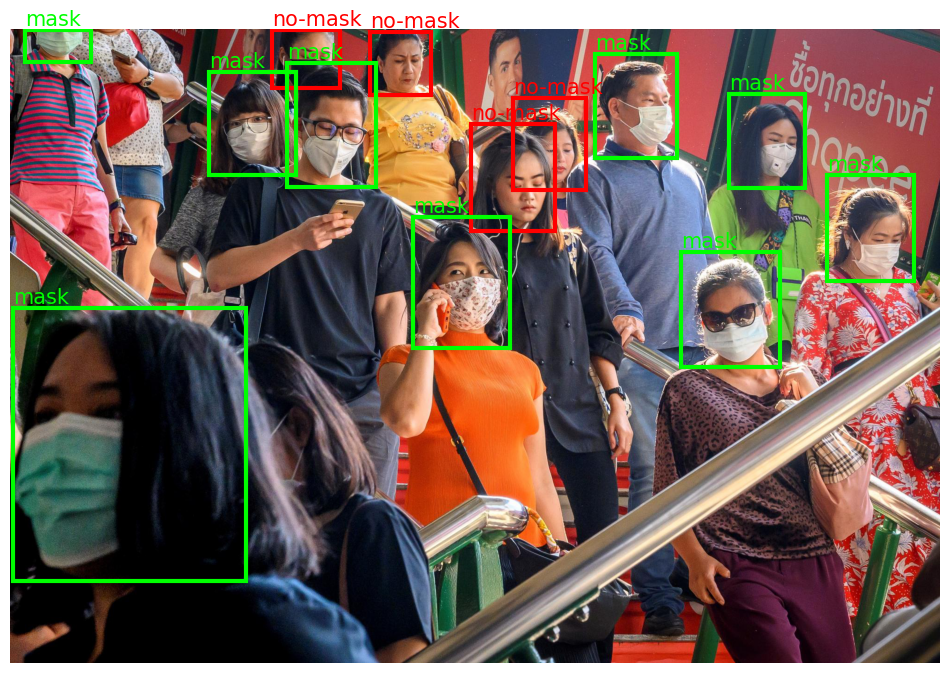

In [36]:
sample_image = train_dir + "/-1x-1_jpg.rf.69d9b61e3cdb8a9047dad25099fcc8ef.jpg"

jsonl_file_location = "./" + train_dir + "/covidmask_train.jsonl"
plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

Image with labels: train/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a82b03b6f60106_jpg.rf.a456219c83b48269ce5adb48d513a350.jpg

Total of labelled objects = 17
- Number of objects labelled 'mask' = 16
- Number of objects labelled 'no-mask' = 1


<Figure size 640x480 with 0 Axes>

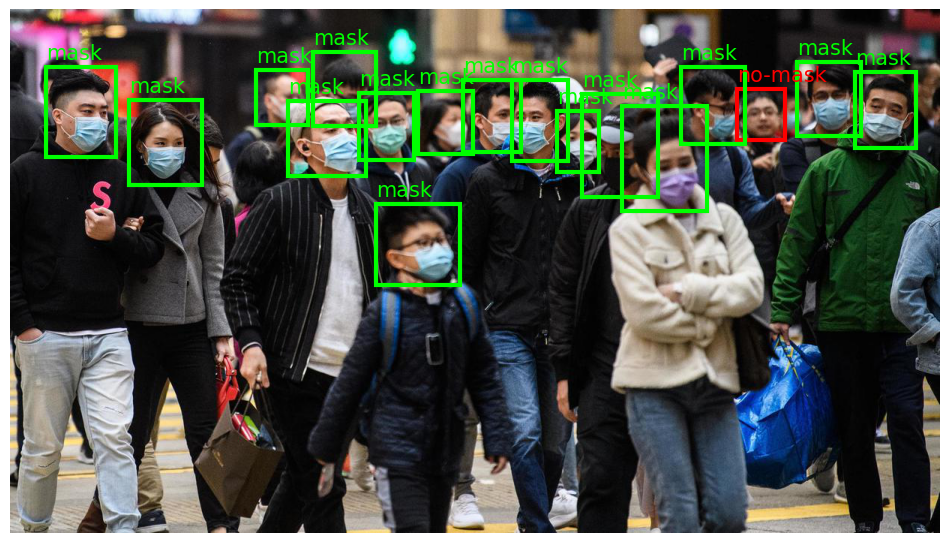

In [37]:
sample_image = 'train/w1240-p16x9-5f8aa310737f8e0e6c43d95a68a82b03b6f60106_jpg.rf.a456219c83b48269ce5adb48d513a350.jpg'

jsonl_file_location = "./" + train_dir + "/covidmask_train.jsonl"
plot_ground_truth_boxes_jsonl(sample_image, jsonl_file_location)

### Upload the JSONL file and images to Datastore
In order to use the data for training in Azure ML, we upload it to our Azure ML Workspace via a [Datastore](https://docs.microsoft.com/en-us/azure/machine-learning/concept-azure-machine-learning-architecture#datasets-and-datastores). The datastore provides a mechanism for you to upload/download data and interact with it from your remote compute targets. It is an abstraction over Azure Storage.

In [38]:
# Retrieving default datastore that got automatically created when we setup a workspace
ds = ws.get_default_datastore()
ds.upload(src_dir="./train", target_path="train")
ds.upload(src_dir="./valid", target_path="valid")

"Datastore.upload" is deprecated after version 1.0.69. Please use "Dataset.File.upload_directory" to upload your files             from a local directory and create FileDataset in single method call. See Dataset API change notice at https://aka.ms/dataset-deprecation.


Uploading an estimated of 107 files
Target already exists. Skipping upload for train/-1x-1_jpg.rf.69d9b61e3cdb8a9047dad25099fcc8ef.jpg
Target already exists. Skipping upload for train/-I1-MS09uaqsLdGTFkgnS0Rcg1mmPyAj95ySg_eckoM_jpeg.rf.b60002517c9371bba207314a49452cf1.jpg
Target already exists. Skipping upload for train/0002526673_jpg.rf.a13de6faa0e2e5250d913ccf27b4c769.jpg
Target already exists. Skipping upload for train/000b7b75-1600_jpg.rf.35b739ea6899972b07aab7225d341307.jpg
Target already exists. Skipping upload for train/000_1ov3n5_0_jpeg.rf.edad89426b118f4c76ba4ae3790b3f31.jpg
Target already exists. Skipping upload for train/001_1024_jpeg.rf.82de51e9c6db87b2941a34e6c65de14a.jpg
Target already exists. Skipping upload for train/003_1024_jpeg.rf.3d3235de8495eb432dc3c54d17287980.jpg
Target already exists. Skipping upload for train/004_1024_jpeg.rf.8387cade019b2c139de783457af677ae.jpg
Target already exists. Skipping upload for train/012106_jpg_1140x855_jpg.rf.b2002b96c6972613f93d98f6

$AZUREML_DATAREFERENCE_1cbe213355b04b1d90059e55837d391c

In [39]:
from azureml.core import Dataset
from azureml.data import DataType

training_dataset_name = 'CovidTrainImagesDataset'

if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print("Found the training dataset", training_dataset_name)

else:
    # create training dataset
    training_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path('train/covidmask_train.jsonl'),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    training_dataset = training_dataset.register(workspace=ws,
                                                 name=training_dataset_name)

print("Training dataset name: " + training_dataset.name)


validation_dataset_name = 'CovidValidationImagesDataset'

if validation_dataset_name in ws.datasets:
    validation_dataset = ws.datasets.get(validation_dataset_name)
    print("Found the validation dataset", validation_dataset_name)

else:
    validation_dataset = Dataset.Tabular.from_json_lines_files(
        path=ds.path('valid/covidmask_valid.jsonl'),
        set_column_types={"image_url": DataType.to_stream(ds.workspace)},
    )
    validation_dataset = validation_dataset.register(
        workspace=ws, name=validation_dataset_name)

print("validation dataset name: " + validation_dataset.name)

Found the training dataset CovidTrainImagesDataset
Training dataset name: CovidTrainImagesDataset
Found the validation dataset CovidValidationImagesDataset
validation dataset name: CovidValidationImagesDataset


Validation dataset is optional. If no validation dataset is specified, by default 20% of your training data will be used for validation. You can control the percentage using the `split_ratio` argument - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#model-agnostic-hyperparameters) for more details.

This is what the training dataset looks like:

In [40]:
training_dataset.to_pandas_dataframe().shape

(105, 3)

In [41]:
training_dataset.to_pandas_dataframe().head(10)

,image_url,image_details,label
0,workspaceblobstore/train/11893820-3x2-xlarge_j...,"{'format': 'jpg', 'width': 862, 'height': 575}","[{'label': 'mask', 'topX': 0.4466357308584687,..."
1,workspaceblobstore/train/130624011830-malaysia...,"{'format': 'jpg', 'width': 980, 'height': 552}","[{'label': 'mask', 'topX': 0.7561224489795918,..."
2,workspaceblobstore/train/1125506397_1580132220...,"{'format': 'jpg', 'width': 900, 'height': 630}","[{'label': 'mask', 'topX': 0.04888888888888889..."
3,workspaceblobstore/train/upload-productImg-152...,"{'format': 'jpg', 'width': 600, 'height': 600}","[{'label': 'mask', 'topX': 0.08166666666666667..."
4,workspaceblobstore/train/1249493_jpg.rf.0bab72...,"{'format': 'jpg', 'width': 1012, 'height': 645}","[{'label': 'no-mask', 'topX': 0.59387351778656..."
5,workspaceblobstore/train/1_13_jpg.rf.042a2d012...,"{'format': 'jpg', 'width': 918, 'height': 506}","[{'label': 'mask', 'topX': 0.8529411764705882,..."
6,workspaceblobstore/train/pollution-mask-CE5HYF...,"{'format': 'jpg', 'width': 1300, 'height': 966}","[{'label': 'mask', 'topX': 0.6307692307692307,..."
7,workspaceblobstore/train/pjecDNMmCUQmbDoJx1fdq...,"{'format': 'jpg', 'width': 1920, 'height': 1280}","[{'label': 'no-mask', 'topX': 0.7390625, 'topY..."
8,workspaceblobstore/train/smartmi-3pcs-filter-m...,"{'format': 'jpg', 'width': 450, 'height': 463}","[{'label': 'mask', 'topX': 0.6511111111111111,..."
9,workspaceblobstore/train/r1p00017o80q34s9781_j...,"{'format': 'jpg', 'width': 640, 'height': 959}","[{'label': 'no-mask', 'topX': 0.0859375, 'topY..."


In [42]:
validation_dataset.to_pandas_dataframe().shape

(29, 3)

In [43]:
validation_dataset.to_pandas_dataframe().head(10)

,image_url,image_details,label
0,workspaceblobstore/valid/1125506397_1580132220...,"{'format': 'jpg', 'width': 899, 'height': 642}","[{'label': 'mask', 'topX': 0.746384872080089, ..."
1,workspaceblobstore/valid/sdgdsgsg_jpg.rf.22968...,"{'format': 'jpg', 'width': 768, 'height': 768}","[{'label': 'mask', 'topX': 0.00260416666666666..."
2,workspaceblobstore/valid/000_1OC3DT_jpg.rf.3d1...,"{'format': 'jpg', 'width': 1024, 'height': 682}","[{'label': 'mask', 'topX': 0.828125, 'topY': 0..."
3,workspaceblobstore/valid/shutterstock_11459335...,"{'format': 'jpg', 'width': 1024, 'height': 770}","[{'label': 'mask', 'topX': 0.501953125, 'topY'..."
4,workspaceblobstore/valid/002_1024_jpeg.rf.2116...,"{'format': 'jpg', 'width': 1024, 'height': 576}","[{'label': 'mask', 'topX': 0.3046875, 'topY': ..."
5,workspaceblobstore/valid/1197315184_jpg_0_jpg....,"{'format': 'jpg', 'width': 1200, 'height': 800}","[{'label': 'mask', 'topX': 0.15666666666666668..."
6,workspaceblobstore/valid/w1240-p16x9-coronavir...,"{'format': 'jpg', 'width': 1240, 'height': 698}","[{'label': 'mask', 'topX': 0.19193548387096773..."
7,workspaceblobstore/valid/r1400018548960op29s_j...,"{'format': 'jpg', 'width': 640, 'height': 959}","[{'label': 'mask', 'topX': 0.225, 'topY': 0.06..."
8,workspaceblobstore/valid/stock-photo-mother-an...,"{'format': 'jpg', 'width': 1001, 'height': 1600}","[{'label': 'mask', 'topX': 0.6843156843156843,..."
9,workspaceblobstore/valid/0009S6815V3PEU1N-C123...,"{'format': 'jpg', 'width': 915, 'height': 660}","[{'label': 'mask', 'topX': 0.00109289617486338..."


Now we are ready to train an object detection model using AutoML for Images

## 6. Configuring your AutoML run for image tasks
AutoML allows you to easily train models for Image Classification, Object Detection & Instance Segmentation on your image data. You can control the model algorithm to be used, specify hyperparameter values for your model as well as perform a sweep across the hyperparameter space to generate an optimal model. Parameters for configuring your AutoML Image run are specified using the `AutoMLImageConfig` - please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-your-experiment-settings) for the details on the parameters that can be used and their values.

When using AutoML for image tasks, you need to specify the model algorithms using the `model_name` parameter. You can either specify a single model or choose to sweep over multiple models. Please refer to the [documentation](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#configure-model-algorithms-and-hyperparameters) for the list of supported model algorithms.

Supported Algorithms https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms

### Using default hyperparameter values for the specified algorithm
Before doing a large sweep to search for the optimal models and hyperparameters, we recommend trying the default values for a given model to get a first baseline. Next, you can explore multiple hyperparameters for the same model before sweeping over multiple models and their parameters. This allows an iterative approach, as with multiple models and multiple hyperparameters for each (as we showcase in the next section), the search space grows exponentially, and  you need more iterations to find optimal configurations.

If you wish to use the default hyperparameter values for a given algorithm (say `yolov5`), you can specify the config for your AutoML Image runs as follows:

In [44]:
CVALGO = 'yolov5'
print("Let's train a", CVALGO, "object detection model...")

Let's train a yolov5 object detection model...


In [45]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

image_config_yolov5 = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,  # Objet Detection
    compute_target=compute_target,  # our GPU Compute to use
    training_data=training_dataset,  # Training images
    validation_data=validation_dataset,  # Validation images
    hyperparameter_sampling=GridParameterSampling({
        "model_name": choice(CVALGO),  # use of Yolov5
    }),
    iterations=1,  # Only 1 model to train here
)

### Submitting an AutoML run for Computer Vision tasks
Once you've created the config settings for your run, you can submit an AutoML run using the config in order to train a vision model using your training dataset.

In [46]:
automl_image_run = experiment.submit(image_config_yolov5)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-MaskDetection,AutoML_71a9bcc7-b9f7-4c47-8449-a28465045a61,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


In [47]:
automl_image_run.wait_for_completion(wait_post_processing = True)

{'runId': 'AutoML_71a9bcc7-b9f7-4c47-8449-a28465045a61',
 'target': 'AutoML-GPU',
 'status': 'Completed',
 'startTimeUtc': '2022-06-21T12:04:10.341009Z',
 'endTimeUtc': '2022-06-21T12:21:28.574422Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-GPU',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlforImages-MaskDetection","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-GPU","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"iterations":1,"primary_me

In [48]:
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

In [50]:
print("Model is:", model_name)
print("\nModel properties:\n", best_child_run.properties)
algo = best_child_run.properties['run_algorithm']
print("\nCV algorithm:", algo)

Model is: AutoML71a9bcc7b0

Model properties:
 {'_azureml.ComputeTargetType': 'amlctrain', 'ContentSnapshotId': 'a8d54f02-f1aa-47d1-848d-dfe4f7068653', 'ProcessInfoFile': 'azureml-logs/process_info.json', 'ProcessStatusFile': 'azureml-logs/process_status.json', 'score': '0.7699244936466049', 'model_name': 'AutoML71a9bcc7b0', 'runTemplate': 'automl_child', 'run_algorithm': 'yolov5', 'model_output_path': 'outputs/model.pt', 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_71a9bcc7-b9f7-4c47-8449-a28465045a61_HD_0/outputs/scoring_file_v_1_0_0.py', 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_71a9bcc7-b9f7-4c47-8449-a28465045a61_HD_0/outputs/conda_env_v_1_0_0.yml', 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_71a9bcc7-b9f7-4c47-8449-a28465045a61_HD_0/outputs/model.pt'}

CV algorithm: yolov5


In [51]:
print("Metrics for the best autoML model:", algo)

automl_metrics = automl_image_run.get_metrics()
per_label_metrics = automl_metrics['per_label_metrics']
per_label_metrics

Metrics for the best autoML model: yolov5


["{0: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.02392, 'recall': 0.46479, 'average_precision': 0.02497}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.01522, 'recall': 0.69014, 'average_precision': 0.04356}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.02132, 'recall': 0.83099, 'average_precision': 0.11913}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.05144, 'recall': 0.91549, 'average_precision': 0.26528}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.09609, 'recall': 0.9507, 'average_precision': 0.53167}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': 0.13031, 'recall': 0.99296, 'average_precision': 0.57291}, 1: {'precision': -1.0, 'recall': 0.0, 'average_precision'

In [52]:
# Let's create a dir to save our model results
MODEL_DIR = 'model'

if path.os.path.isdir(MODEL_DIR):
    print("Directory:", MODEL_DIR, "exists")

else:
    print("Directory", MODEL_DIR, "did not exist.")
    print("Creating directory:", MODEL_DIR)
    os.mkdir(MODEL_DIR)
    print("Done.")

Directory model did not exist.
Creating directory: model
Done.


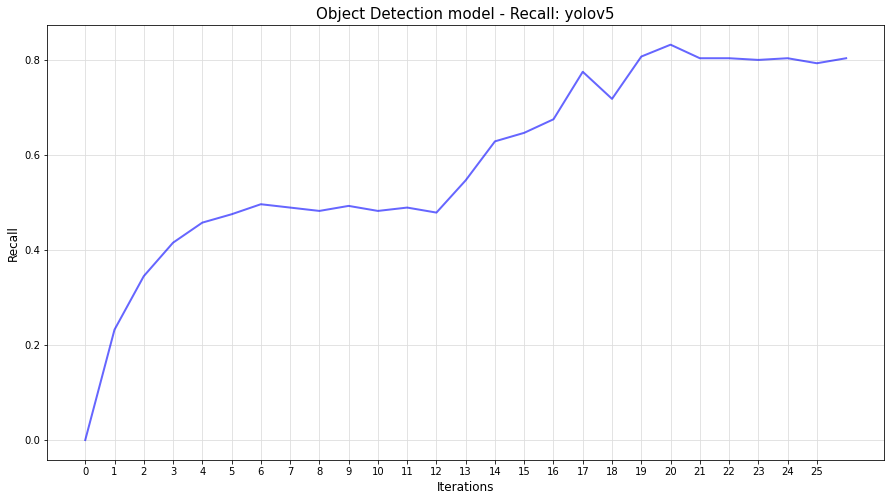

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(automl_metrics['recall'], 'b-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Object Detection model - Recall: ' + algo, fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 26, 1))

plt.savefig(MODEL_DIR + '/recall_' + algo + '.png')
plt.show()

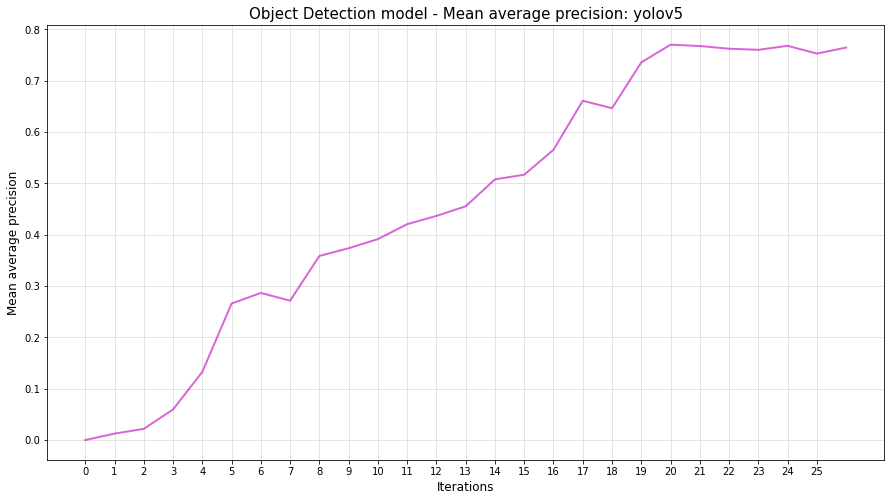

In [54]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automl_metrics['mean_average_precision'], 'm-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Mean average precision', fontsize=12)
plt.title('Object Detection model - Mean average precision: ' + algo,
          fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 26, 1))

plt.savefig(MODEL_DIR + '/mean_average_precision_' + algo + '.png')
plt.show()

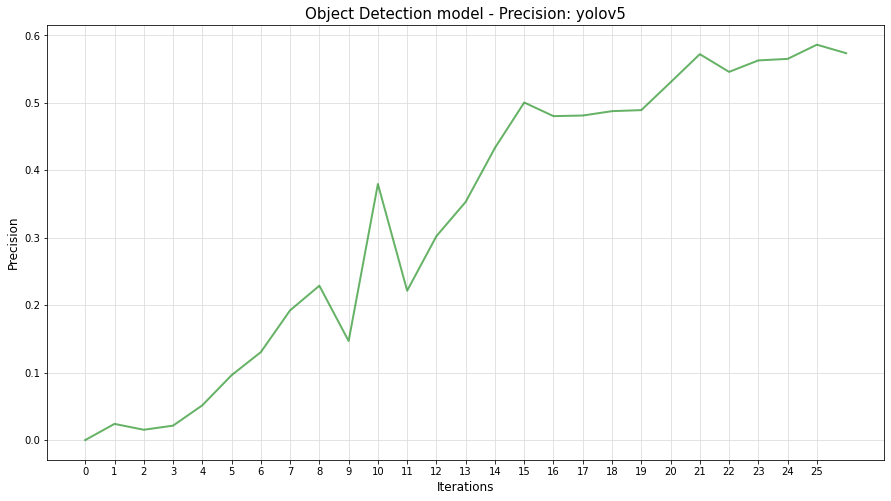

In [55]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automl_metrics['precision'], 'g-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Object Detection model - Precision: ' + algo, fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 26, 1))

plt.savefig(MODEL_DIR + '/precision_' + algo + '.png')
plt.show()

Plots have been saved here:

In [56]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-21 12:35:20.722906 mean_average_precision_yolov5.png 29.6 kB
2022-06-21 12:35:21.296579 precision_yolov5.png 31.4 kB
2022-06-21 12:35:16.382378 recall_yolov5.png 23.4 kB


We will improve the results. We can use now some advanced options and trying different algorithms

> https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#supported-model-algorithms
> https://docs.microsoft.com/en-us/azure/machine-learning/reference-automl-images-hyperparameters

In [117]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import BanditPolicy, RandomParameterSampling
from azureml.train.hyperdrive import choice, uniform

parameter_space = {
    "model": choice(
        {
            "model_name": choice("yolov5"),
            "model_size": choice("medium", "large"),
        },
        {
            "model_name": choice("fasterrcnn_resnet34_fpn", 
                                 "retinanet_resnet50_fpn",
                                 "fasterrcnn_resnet101_fpn",
                                ),
            "learning_rate": uniform(0.0001, 0.001),
            "optimizer": choice("sgd", "adam", "adamw"),
            "warmup_cosine_lr_warmup_epochs" : choice(0, 3),
        },
    ),
}

tuning_settings = {
    "iterations": 20,
    "max_concurrent_iterations": 4,
    "hyperparameter_sampling": RandomParameterSampling(parameter_space),
    "early_termination_policy": BanditPolicy(
        evaluation_interval=2, slack_factor=0.2, delay_evaluation=6
    ),
}

automl_image_config = AutoMLImageConfig(
    task=ImageTask.IMAGE_OBJECT_DETECTION,
    compute_target=compute_target,
    training_data=training_dataset,
    validation_data=validation_dataset,
    **tuning_settings,
)

In [118]:
automl_image_run = experiment.submit(automl_image_config)
automl_image_run.wait_for_completion(wait_post_processing=True)

Submitting remote run.


Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-MaskDetection,AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e,automl,NotStarted,Link to Azure Machine Learning studio,Link to Documentation


{'runId': 'AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e',
 'target': 'AutoML-GPU-cluster',
 'status': 'Completed',
 'startTimeUtc': '2022-06-21T14:27:42.634334Z',
 'endTimeUtc': '2022-06-21T15:34:28.622776Z',
 'services': {},
 'properties': {'num_iterations': '1',
  'training_type': 'TrainFull',
  'acquisition_function': 'EI',
  'primary_metric': 'mean_average_precision',
  'train_split': '0',
  'acquisition_parameter': '0',
  'num_cross_validation': None,
  'target': 'AutoML-GPU-cluster',
  'AMLSettingsJsonString': '{"path":null,"name":"AutomlforImages-MaskDetection","subscription_id":"70b8f39e-8863-49f7-b6ba-34a80799550c","resource_group":"azuremlvision-rg","workspace_name":"azuremlvision","region":"westeurope","compute_target":"AutoML-GPU-cluster","spark_service":null,"azure_service":"remote","many_models":false,"pipeline_fetch_max_batch_size":1,"enable_batch_run":true,"enable_run_restructure":false,"start_auxiliary_runs_before_parent_complete":false,"enable_code_generation":false,"i

In [119]:
#from azureml.widgets import RunDetails
#RunDetails(automl_image_run).show()

In [120]:
from azureml.core import Run

hyperdrive_run = Run(experiment=experiment, run_id=automl_image_run.id + "_HD")
hyperdrive_run

Experiment,Id,Type,Status,Details Page,Docs Page
AutomlforImages-MaskDetection,AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD,hyperdrive,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [121]:
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']
print("Model is:", model_name)

Model is: AutoMLf72e704fb2


In [122]:
best_child_run.properties

{'_azureml.ComputeTargetType': 'amlctrain',
 'ContentSnapshotId': '3df82509-9e99-462e-bbf2-41dd937d4434',
 'ProcessInfoFile': 'azureml-logs/process_info.json',
 'ProcessStatusFile': 'azureml-logs/process_status.json',
 'score': '0.8877067403132237',
 'model_name': 'AutoMLf72e704fb2',
 'runTemplate': 'automl_child',
 'run_algorithm': 'fasterrcnn_resnet101_fpn',
 'model_output_path': 'outputs/model.pt',
 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/scoring_file_v_1_0_0.py',
 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/conda_env_v_1_0_0.yml',
 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/model.pt'}

In [123]:
# List of all the AutoML for Images metrics values
bestautoml_algorithm = best_child_run.properties['run_algorithm']
print("CV algorithm =", bestautoml_algorithm)
automlmetrics = automl_image_run.get_metrics()
per_label_metrics = automlmetrics['per_label_metrics']
per_label_metrics

CV algorithm = fasterrcnn_resnet101_fpn


["{0: {'precision': -1.0, 'recall': -1.0, 'average_precision': -1.0}, 1: {'precision': 0.30769, 'recall': 0.02817, 'average_precision': 0.01127}, 2: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': -1.0, 'recall': -1.0, 'average_precision': -1.0}, 1: {'precision': 0.3075, 'recall': 0.8662, 'average_precision': 0.66302}, 2: {'precision': -1.0, 'recall': 0.0, 'average_precision': 0.0}}",
 "{0: {'precision': -1.0, 'recall': -1.0, 'average_precision': -1.0}, 1: {'precision': 0.6, 'recall': 0.88732, 'average_precision': 0.80471}, 2: {'precision': 0.33333, 'recall': 0.1, 'average_precision': 0.07}}",
 "{0: {'precision': -1.0, 'recall': -1.0, 'average_precision': -1.0}, 1: {'precision': 0.62981, 'recall': 0.92254, 'average_precision': 0.86303}, 2: {'precision': 0.35714, 'recall': 0.25, 'average_precision': 0.18869}}",
 "{0: {'precision': -1.0, 'recall': -1.0, 'average_precision': -1.0}, 1: {'precision': 0.66, 'recall': 0.92958, 'average_precision': 0.88213},

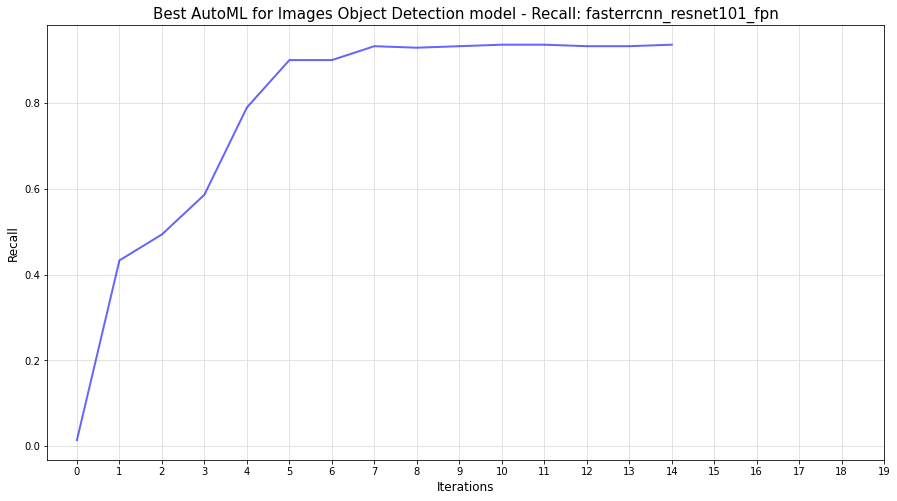

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.plot(automlmetrics['recall'], 'b-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Best AutoML for Images Object Detection model - Recall: ' +
          bestautoml_algorithm,
          fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 20, 1))

plt.savefig(MODEL_DIR + '/recall_bestmodel_' + bestautoml_algorithm + '.png')
plt.show()

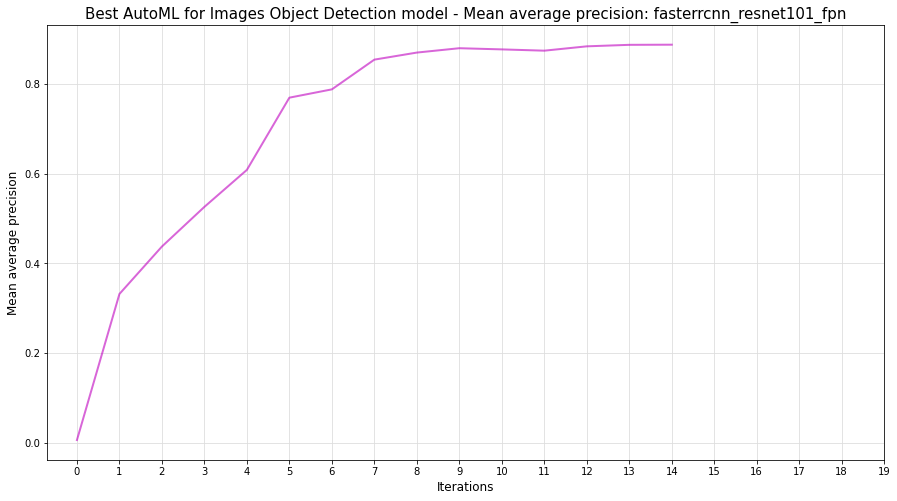

In [125]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automlmetrics['mean_average_precision'], 'm-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Mean average precision', fontsize=12)
plt.title(
    'Best AutoML for Images Object Detection model - Mean average precision: '
    + bestautoml_algorithm,
    fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 20, 1))

plt.savefig(MODEL_DIR + '/mean_average_precision_bestmodel_' +
            bestautoml_algorithm + '.png')
plt.show()

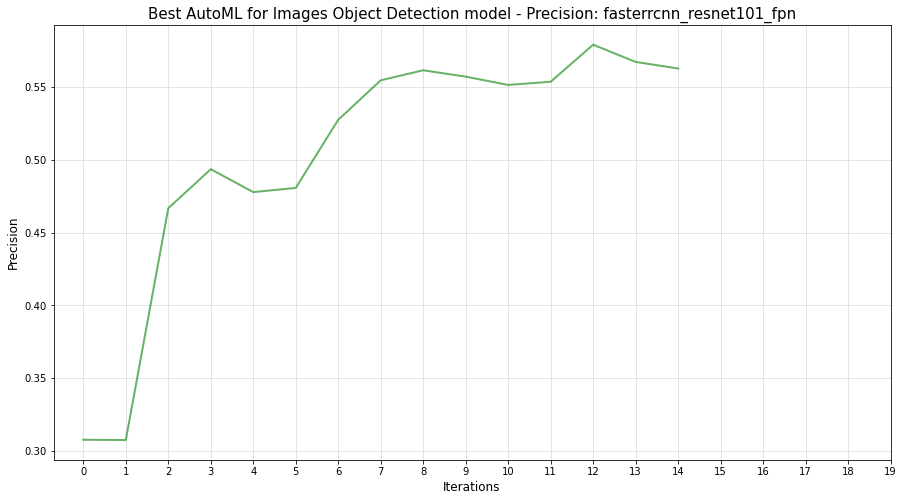

In [126]:
%matplotlib inline

plt.figure(figsize=(15, 8))
plt.plot(automlmetrics['precision'], 'g-', lw=2, alpha=0.6)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Best AutoML for Images Object Detection model - Precision: ' +
          bestautoml_algorithm,
          fontsize=15)
plt.grid(color='#DDDDDD', linewidth=0.8)
plt.xticks(np.arange(0, 20, 1))

plt.savefig(MODEL_DIR + '/precision_bestmodel_' + bestautoml_algorithm +
            '.png')
plt.show()

Plots have been saved here:

In [127]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-21 14:17:53.081166 labels.json 29 Bytes
2022-06-21 15:34:50.376043 mean_average_precision_bestmodel_fasterrcnn_resnet101_fpn.png 27.4 kB
2022-06-21 14:17:29.145809 mean_average_precision_bestmodel_fasterrcnn_resnet50_fpn.png 31.7 kB
2022-06-21 12:35:20.722906 mean_average_precision_yolov5.png 29.6 kB
2022-06-21 14:17:42.632123 model.onnx 165.6 MB
2022-06-21 14:17:52.342586 model.pt 494.4 MB
2022-06-21 15:34:50.891753 precision_bestmodel_fasterrcnn_resnet101_fpn.png 28.3 kB
2022-06-21 14:17:29.733474 precision_bestmodel_fasterrcnn_resnet50_fpn.png 33.7 kB
2022-06-21 12:35:21.296579 precision_yolov5.png 31.4 kB
2022-06-21 15:34:49.888319 recall_bestmodel_fasterrcnn_resnet101_fpn.png 22.9 kB
2022-06-21 14:17:28.336270 recall_bestmodel_fasterrcnn_resnet50_fpn.png 27.2 kB
2022-06-21 12:35:16.382378 recall_yolov5.png 23.4 kB
2022-06-21 14:17:53.778768 score.py 2.2 kB


You can use the AutoML hyperparameter tuning options to build and train your models:https://docs.microsoft.com/en-us/azure/machine-learning/reference-automl-images-hyperparameters

## 7. Register the optimal vision model from the AutoML run
Once the run completes, we can register the model that was created from the best run (configuration that resulted in the best primary metric)

In [128]:
# Register the best model from the AutoML Vision run
best_child_run = automl_image_run.get_best_child()
model_name = best_child_run.properties['model_name']

In [129]:
best_child_run.properties

{'_azureml.ComputeTargetType': 'amlctrain',
 'ContentSnapshotId': '3df82509-9e99-462e-bbf2-41dd937d4434',
 'ProcessInfoFile': 'azureml-logs/process_info.json',
 'ProcessStatusFile': 'azureml-logs/process_status.json',
 'score': '0.8877067403132237',
 'model_name': 'AutoMLf72e704fb2',
 'runTemplate': 'automl_child',
 'run_algorithm': 'fasterrcnn_resnet101_fpn',
 'model_output_path': 'outputs/model.pt',
 'scoring_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/scoring_file_v_1_0_0.py',
 'conda_env_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/conda_env_v_1_0_0.yml',
 'model_data_location': 'aml://artifact/ExperimentRun/dcid.AutoML_f72e704f-b6f0-4bfc-bd7d-0d6ec05ed10e_HD_2/outputs/model.pt'}

In [130]:
bestautoml_algorithm = best_child_run.properties['run_algorithm']
print("CV algorithm best model =", bestautoml_algorithm)

CV algorithm best model = fasterrcnn_resnet101_fpn


In [131]:
# Description of the CV model
cvmodel_desc = "Computer vision model to detect Covid-19 mask using: "\
+ str(bestautoml_algorithm)

# Defining tags for the custom vision model
cvmodel_tags = {
    "Data": "Images",
    "Context": "Covid19 Mask Detection",
    "Type": "Object Detection",
    "Algorithms": bestautoml_algorithm,
    "Task": "Azure AutoML for Images",
}

In [132]:
model = best_child_run.register_model(model_name=model_name,
                                      model_path='outputs/model.pt',
                                      description=cvmodel_desc,
                                      tags=cvmodel_tags)

In [133]:
# Let's download the ONNX model file
best_child_run.download_file('train_artifacts/model.onnx',
                             output_file_path=MODEL_DIR + '/model.onnx')

In [134]:
# Let's download the PyTorch model file
best_child_run.download_file('train_artifacts/model.pt',
                             output_file_path=MODEL_DIR + '/model.pt')

In [135]:
# Let's download the labels file
best_child_run.download_file('train_artifacts/labels.json',
                             output_file_path=MODEL_DIR + '/labels.json')

In [136]:
with open(MODEL_DIR + '/labels.json', 'r') as f:
    print(f.read())

["--bg--", "mask", "no-mask"]


Model artifacts have been saved here:

In [137]:
listfiles(MODEL_DIR)

Files in: model 

2022-06-21 15:35:12.431602 labels.json 29 Bytes
2022-06-21 15:34:50.376043 mean_average_precision_bestmodel_fasterrcnn_resnet101_fpn.png 27.4 kB
2022-06-21 14:17:29.145809 mean_average_precision_bestmodel_fasterrcnn_resnet50_fpn.png 31.7 kB
2022-06-21 12:35:20.722906 mean_average_precision_yolov5.png 29.6 kB
2022-06-21 15:35:03.270772 model.onnx 241.6 MB
2022-06-21 15:35:12.121778 model.pt 482.1 MB
2022-06-21 15:34:50.891753 precision_bestmodel_fasterrcnn_resnet101_fpn.png 28.3 kB
2022-06-21 14:17:29.733474 precision_bestmodel_fasterrcnn_resnet50_fpn.png 33.7 kB
2022-06-21 12:35:21.296579 precision_yolov5.png 31.4 kB
2022-06-21 15:34:49.888319 recall_bestmodel_fasterrcnn_resnet101_fpn.png 22.9 kB
2022-06-21 14:17:28.336270 recall_bestmodel_fasterrcnn_resnet50_fpn.png 27.2 kB
2022-06-21 12:35:16.382378 recall_yolov5.png 23.4 kB
2022-06-21 14:17:53.778768 score.py 2.2 kB


We have saved our best model. It is time to deploy it now

## 8. Deploy model as a web service
Once you have your trained model, you can deploy the model on Azure. You can deploy your trained model as a web service on Azure Container Instances ([ACI](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-container-instance)) or Azure Kubernetes Service ([AKS](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-azure-kubernetes-service)). Please note that ACI only supports small models under 1 GB in size. For testing larger models or for the high-scale production stage, we recommend using AKS.
In this tutorial, we will deploy the model as a web service in AKS.

You will need to first create an AKS compute cluster or use an existing AKS cluster. You can use either GPU or CPU VM SKUs for your deployment cluster

In [138]:
%%time
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your inference cluster
aks_name = "aks-clustertest"

# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print('Found existing inference cluster:', aks_name)

except ComputeTargetException:
    print('Creating a new inference cluster ...')
    # Provision AKS cluster with GPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_NC6",
                                                        location="eastus2")
    aks_target = ComputeTarget.create(workspace=ws,
                                      name=aks_name,
                                      provisioning_configuration=prov_config)

    aks_target.wait_for_completion(show_output=True)
    print("Done. Inference cluster has been created:", aks_name)

Found existing inference cluster: aks-clustertest
CPU times: user 0 ns, sys: 22.4 ms, total: 22.4 ms
Wall time: 112 ms


Next, you will need to define the [inference configuration](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-auto-train-image-models#update-inference-configuration), that describes how to set up the web-service containing your model. You can use the scoring script and the environment from the training run in your inference config.

<b>Note:</b> To change the model's settings, open the downloaded scoring script and modify the model_settings variable <i>before</i> deploying the model.

In [139]:
endpoint_name = "covid19-mask-detection-model"  # Name of the endpoint to create

aks_tags = {
    "Data": "Images",
    "Topic": "Mask Detection",
    "Task": "Object Detection",
    "Algorithm": bestautoml_algorithm,
    "Framework": "AutoML for Images best model",
    "AKS": "True"
}

aks_description = "Computer vision model to detect Covid-19 mask from an image"

In [140]:
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AksWebservice
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment

best_child_run.download_file('outputs/scoring_file_v_1_0_0.py',
                             output_file_path='model/score.py')

environment = best_child_run.get_environment()

inference_config = InferenceConfig(entry_script='model/score.py',
                                   environment=environment)

aks_config = AksWebservice.deploy_configuration(autoscale_enabled=True,
                                                cpu_cores=1,
                                                memory_gb=50,
                                                enable_app_insights=True,
                                                description=aks_description,
                                                tags=aks_tags)

You can then deploy the model as an AKS web service:

In [141]:
%%time

print("Deploying the model endpoint:", endpoint_name, "into the AKS cluster:",
      aks_name, "...\n")

aks_service = Model.deploy(ws,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target,
                           name=endpoint_name,
                           overwrite=True)

aks_service.wait_for_deployment(show_output=True)

print("\nDone. Model has been deployed.")

Deploying the model endpoint: covid19-mask-detection-model into the AKS cluster: aks-clustertest ...

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2022-06-21 15:35:19+00:00 Creating Container Registry if not exists.
2022-06-21 15:35:19+00:00 Registering the environment.
2022-06-21 15:35:20+00:00 Use the existing image.
2022-06-21 15:35:21+00:00 Creating resources in AKS.
2022-06-21 15:35:24+00:00 Submitting deployment to compute.
2022-06-21 15:35:24+00:00 Checking the status of deployment covid19-mask-detection-model..
2022-06-21 15:42:16+00:00 Checking the status of inference endpoint covid19-mask-detection-model.
Succeeded
AKS service creation operation finished, operation "Succeeded"

Done. Model has been deployed.
CPU times: user 1.85 s, sys: 228 ms, total: 2.08 s
Wall time: 7min 9s


In [142]:
print(datetime.datetime.now(), " Our deployed model status is:", 
      aks_service.state)

2022-06-21 15:42:22.993012  Our deployed model status is: Healthy


> Model has been trained and deployed. We can test it now. You can access to notebook Part 2 to test the deployed model